 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
N = 9
errors[1] = 0.05642361111111106
errors[2] = 0.056423611111111084
errors[3] = 0.05642361111111108
errors[4] = 0.056423611111111084
errors[5] = 0.056423611111111084
nonzeroratio = nonzerocounter / (N * N) = 1.0
N = 17
errors[1] = 0.02952665441176818
errors[2] = 0.029526654411768154
errors[3] = 0.02952665441176591
errors[4] = 0.029526654411768077
errors[5] = 0.029526654411768095
nonzeroratio = nonzerocounter / (N * N) = 1.0
N = 33
errors[1] = 0.01516631155302957
errors[2] = 0.015166311553029384

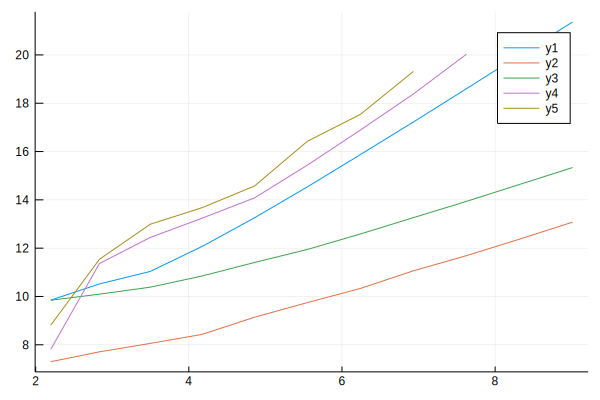

In [50]:
using Pkg
using LinearAlgebra
using SparseArrays

Pkg.add("Statistics")
using Statistics
mean
Pkg.add("Plots")
using Plots
Pkg.add("BenchmarkTools")
using BenchmarkTools


function make_matrix(N,alpha_thermal)
    h=1/(N-1)
    dl = -1/h*ones(N-1);
    du = -1/h*ones(N-1);
    d = 1/h*2*ones(N);

    d[1]=1/h+alpha_thermal
    d[N]=1/h+alpha_thermal
    A=Tridiagonal(dl, d, du)
    return A
end

function Progonka(A,f)
    N=length(f)
    u=zeros(N)
    a=[0;diag(A[2:end,1:end-1])]
    b=diag(A)
    c=diag(A[1:end-1,2:end])
    alpha=zeros(N)
    beta=zeros(N)

    alpha[2]=-c[1]/b[1]
    beta[2]=f[1]/b[1]

    for i in 2:N-1
        alpha[i+1]=-c[i]/(a[i]*alpha[i]+b[i])
        beta[i+1]=(f[i]-a[i]*beta[i])/(a[i]*alpha[i]+b[i])
    end
    u[N]=(f[N]-a[N]*beta[N])/(a[N]*alpha[N]+b[N])
    for i in N-1:-1:1
        u[i]=alpha[i+1]*u[i+1]+beta[i+1]
    end
    return u
end

k_init=3
iterations=11
k_final=k_init+iterations-1
N_list=exp2.(collect(k_init:k_final)).+1


global errors=zeros(5,iterations)
global times=zeros(5,iterations)

global alpha_thermal=1
global v_l=0
global v_r=0

for k in k_init:k_final
    N=2^k+1
    @show N
    h=1/(N-1)
    u_real=-h^2/2*collect(1:N).*collect(1:N) .+ h/2*collect(1:N) .+ 1/(2*alpha_thermal)
    f=h*ones(N)
    f[1]=alpha_thermal*v_l
    f[N]=alpha_thermal*v_r

    A=make_matrix(N,alpha_thermal)


    errors[1,k-k_init+1]=norm(u_real-Progonka(A,f),1)/N
    @show errors[1,k-k_init+1]
    t=@benchmark Progonka($A,$f)
    times[1,k-k_init+1]=mean(t).time

    errors[2,k-k_init+1]=norm(u_real-A\f,1)/N
    @show errors[2,k-k_init+1]
    t=@benchmark $A\$f
    times[2,k-k_init+1]=mean(t).time

    A=sparse(A)
    errors[3,k-k_init+1]=norm(u_real-A\f,1)/N
    @show errors[3,k-k_init+1]
    t=@benchmark $A\$f
    times[3,k-k_init+1]=mean(t).time

    try
        A=Matrix(A)
        errors[4,k-k_init+1]=norm(u_real-A\f,1)/N
        @show errors[4,k-k_init+1]
        t=@benchmark $A\$f
        times[4,k-k_init+1]=mean(t).time

        A_inv=inv(A)
        errors[5,k-k_init+1]=norm(u_real-A_inv*f,1)/N
        @show errors[5,k-k_init+1]
        t=@benchmark inv($A)*$f
        times[5,k-k_init+1]=mean(t).time      

        nonzerocounter = 0;
        for i = 1:N
            for j = 1:N
                if A_inv[i,j] != 0
                    nonzerocounter = nonzerocounter + 1;
                end
            end
        end
        @show nonzeroratio=nonzerocounter/(N*N)
    catch e
           println("N too big for full matrix")
    end
    



end

plot(log.(N_list),log.(times[1,:]))
plot!(log.(N_list),log.(times[2,:]))
plot!(log.(N_list),log.(times[3,:]))
plot!(log.(N_list),log.(times[4,:]))
plot!(log.(N_list),log.(times[5,:]))

In [52]:
errors

5×11 Array{Float64,2}:
 6.10277e-5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.10277e-5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.10277e-5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.10277e-5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.000244022  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

exp (generic function with 14 methods)